In [17]:
import numpy as np
import scipy.linalg as la
import itertools as it
import time
import pylab as pl
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from tqdm import tqdm
import numpy as np
#import pylab as pl
import random
import matplotlib as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.lines import Line2D
#from scipy.stats import norm
import os
import scipy.io as sio
import pickle

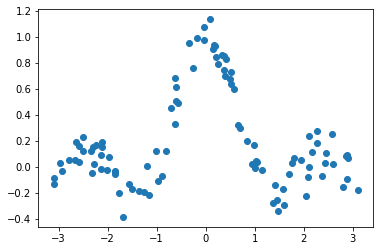

In [18]:
# Test
def noisysincfunction(N, noise):
    ''' noisysincfunction - generate data from the "noisy sinc function"
        % usage
        %     [X, Y] = noisysincfunction(N, noise)
        %
        % input
        %     N: number of data points
        %     noise: standard variation of the noise
        %
        % output
        %     X: (1, N)-matrix uniformly sampled in -2pi, pi
        %     Y: (1, N)-matrix equal to sinc(X) + noise
        %
        % description
        %     Generates N points from the noisy sinc function
        %
        %        X ~ uniformly in [-2pi, pi]
        %        Y = sinc(X) + eps, eps ~ Normal(0, noise.^2)
        %
        % author
        %     Mikio Braun
    '''
    X = np.sort(2 * np.pi * np.random.rand(1, N) ) - np.pi
    Y = np.sinc(X) + noise * np.random.randn(1, N)
    return X.reshape(-1, 1), Y.flatten()
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)
pl.plot(Xtr,Ytr, 'o')

In [3]:
def zero_one_loss(y_true, y_pred):
    ''' your header here!
    '''
    

In [4]:
def mean_absolute_error(y_true, y_pred):
    ''' 
    your code here 
    '''
    loss = np.mean(abs(y_pred-y_true))
    #loss = np.sum(np.sum((y_pred-y_true)**2)**0.5, axis = 1) / len(y_pred)
    return loss

In [5]:
def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    ''' 
    your header here!
    '''
    # TODO progress bar, run time estimation
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int')) 
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
    #print(method.params)
    method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
    return method

In [12]:
class krr():
    ''' your header here!
    '''
    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        ''' your header here!
        '''
        self.__Xtrain = X
        self.__ytrain = y
        self.ydim = y.reshape(len(y),-1).shape[1]
        
        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        else:
            print("""The following kernel {} is not known. Please use either 'linear' , 'polynomial' or 'gaussian'.""".format(kernel))
        if self.regularization == 0:
            self.__LOOCV()
        
        # calculate optimized alpha
        I_length = len(self.kernelmatrix)
        self.alpha = np.linalg.solve(self.kernelmatrix+self.regularization*np.identity(I_length), self.__ytrain).reshape(-1,len(self.__ytrain))
        
        return self

    def predict(self, X):
        ''' your header here!
        '''
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        # calculate prediction
        y_pred = self.alpha.dot(self.kernelmatrix) # <alpha,kernelmatrix>
        return y_pred.reshape(len(X),self.ydim) #len(self.alpha)
    
    def __linearKernel(self,Y):
        self.kernelmatrix = self.__Xtrain.dot(Y.T)
        
    def __polynomialKernel(self,Y):
        self.kernelmatrix = (self.__Xtrain.dot(Y.T)+1)**self.kernelparameter
        
    def __gaussianKernel(self,Y):
        X_len, X_width = self.__Xtrain.shape
        self.kernelmatrix = np.exp(-(np.diagonal(self.__Xtrain.dot(self.__Xtrain.T)).reshape(X_len, 1)-2*self.__Xtrain.dot(Y.T)+np.diagonal(Y.dot(Y.T)))/(2*(self.kernelparameter**2)))
        
    def __LOOCV(self):
        # Leave-One-Out-Cross-Validation
        # starting squared error
        #min_squared_loss = 1000
        # Eigenvalue decomposition
        squared_loss = []
        L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        # logarithmic distribution with mu = mean_L and sigma = 1
        # create 50 values of C
        # identify C around Kernel eigenvalue means with logarithmic distribution 
        Cs = np.logspace(-10, 10, 50)*mean_L
        for C in Cs: #np.random.lognormal(mean_L,sigma = 1, size = 30):
            ULCI = U.dot(L*I).dot((1/(L + C))*I) # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss.append(np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))))**2) / len(self.__ytrain))
        self.regularization = Cs[np.argmin(squared_loss)]
                
        # Eigenvalue decomposition
        #L, U = np.linalg.eigh(self.kernelmatrix) # L = Eigenvalue, U = Eigenvector
        #mean_L = np.mean(L)        
                
        # create candidates
        #C = np.logspace(-10, 10, 50)*mean_L
        
        #UTy = U.T.dot(self.__ytrain)
        # 
        #UL = U.dot(np.diag(L))[None,:,:]
        #LC = np.diag(L)[None,:,:]+C[:,None,None]*I[None,:,:]
        #ULCI = np.linalg.solve(LC,UL)
        
        #calculate all quadratic losses for c candidates
        #c   =    0xnx1-cxnx1 / (1-cxn)
        #epsilon = (np.sum(((Ytr - ULCI.dot(UTy)) / (1-np.diagonal(ULCI.dot(U.T))).reshape(len(C),len(Ytr)))**2, axis = 1) /len(Ytr))
    
        #best_epsilon = epsilon[np.argmin(epsilon)]
    
        #self.regularization = C[np.argmin(epsilon)]        
        
        return self

In [29]:
""" ps3_implementation.py

PUT YOUR NAME HERE:
<FIRST_NAME><LAST_NAME>


Write the functions
- cv
- zero_one_loss
- krr
Write your implementations in the given functions stubs!


(c) Daniel Bartz, TU Berlin, 2013
"""
import numpy as np
import scipy.linalg as la
import itertools as it
import time
import pylab as pl
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from tqdm import tqdm


def zero_one_loss(y_true, y_pred):
    '''
    Applies a the zero one loss function to predictions.

    Input:
    y_true = the true data labels (nx1)
    y_pred = the predicted data labels (nx1)

    Output:
    loss = the zero one loss
    '''
    loss = np.count_nonzero(y_true != np.sign(y_pred))
    return loss


def mean_absolute_error(y_true, y_pred):
    '''
    your code here
    '''
    loss = np.mean(abs(y_pred-y_true))
    return loss


def cv(X, y, method, params, loss_function=mean_absolute_error, nfolds=10, nrepetitions=5):
    '''
    This function applies a cross validation procedure with a specified loss function and model parameters.

    Inputs:
    X = X training data (nxd)
    y = y training data (nxe)
    method = model
    params = the model parameters: the 'kernel', the 'kernelparameter' and 'regularisation' term.
    loss_function = the loss function to be used to calculate error.
    nfolds = number of equal sized folds
    nrepetitions = number of repetitions

    Outputs:
    method = the model object with the best parameters and cvloss.
    '''
    length, width = np.shape(X)
    # model = method
    method.cvloss = 1000000
    params_combinations = list(it.product(params['kernel'], params['kernelparameter'], params['regularization']))
    for parameter in tqdm(params_combinations):
        #print(parameter[1])
        model = method(parameter[0], parameter[1], parameter[2])
        e = 0
        for i in range(nrepetitions):
            # Random Partitioning
            X_pos = np.linspace(0,length-1, length)
            random.shuffle(X_pos)
            part = np.array_split(X_pos, nfolds)
            for j in range(nfolds):
                # Assign every part not j as training set
                # Xtr indices
                train = np.concatenate(np.array(part)[tuple([np.array(range(nfolds)) != j])].astype('int'))
                X_j = X[train]
                y_j = y[train]
                model.fit(X_j, y_j)
                y_pred = model.predict(X[part[j].astype('int')])
                e = e + loss_function(y[part[j].astype('int')], y_pred)
        e = e / (nfolds * nrepetitions)
        #print('Loss:' + str(model.cvloss))
        if e < method.cvloss:
            #print(e)
            method.cvloss = e
            #print('Loss in if:' + str(model.cvloss))
            method.__params = parameter
    #print(method.params)
    method = model.fit(X,y,method.__params[0],method.__params[1],method.__params[2])
    return method


class krr():
    '''
    This class is used for kernel ridge regression.

    Attributes:
        self.kernel = kernel to be used. Can be linear, gaussian, polynomial.
        self.kernelparameter = the value of the kernelparameter, if relevant.
        self.regularisation = the regularisation constant. If 0, efficient LOOCV is used.

    Methods:
        fit = fits given data to krr model with given parameters.
        pred = uses fitted model to predict new unseen test data.
        __linearKernel = implements a linear kernel
        __polynomialKernel = implements a polynomial kernel with kernelparameter
        __gaussianKernel = implements a gaussian kernel with kernelparameter.
        LOOCV = implements efficient leave one out cross validation to find a regularisation constant for the model.

    Outputs:
    the krr object
    '''

    def __init__(self, kernel='linear', kernelparameter=1, regularization=0):
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization

    def fit(self, X, y, kernel=False, kernelparameter=False, regularization=False):
        '''
        Fits training data to the specified model parameters by calculating alpha. Uses LOOCV is regularization =0.

        Inputs:
        X = training data X
        y = training data y
        kernel = kernel (see krr attributes)
        kernelparameter = kernelparameter
        regularisation = regularisation term

        Outputs:
        fitted model with optimised alpha.

        '''
        self.__Xtrain = X
        self.__ytrain = y
        self.__ydim = y.shape[1]

        if kernel is not False:
            self.kernel = kernel
        if kernelparameter is not False:
            self.kernelparameter = kernelparameter
        if regularization is not False:
            self.regularization = regularization
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        else:
            print(
                """The following kernel {} is not known. Please use either 'linear' , 'polynomial' or 'gaussian'.""".format(
                    kernel))
        if self.regularization == 0:
            self.__LOOCV()

        # calculate optimized alpha
        I_length = len(self.kernelmatrix)
        self.alpha = np.linalg.solve(self.kernelmatrix + self.regularization * np.identity(I_length),self.__ytrain).reshape(-1, len(self.__ytrain))

        return self

    def predict(self, X):
        '''
        Makes y-predictions based on x testing data.

        Input:
        X = xtesting data

        Output
        y_pred = y predictions

        '''
        # calculate kernelmatrix
        if self.kernel == 'linear':
            self.__linearKernel(X)
        elif self.kernel == 'polynomial':
            self.__polynomialKernel(X)
        elif self.kernel == 'gaussian':
            self.__gaussianKernel(X)
        # calculate prediction
        y_pred = self.alpha.dot(self.kernelmatrix)  # <alpha,kernelmatrix>
        return y_pred.reshape(len(X), self.__ydim)  # len(self.alpha)

    def __linearKernel(self, Y):
        self.kernelmatrix = self.__Xtrain.dot(Y.T)

    def __polynomialKernel(self, Y):
        self.kernelmatrix = (self.__Xtrain.dot(Y.T) + 1) ** self.kernelparameter

    def __gaussianKernel(self, Y):
        X_len, X_width = self.__Xtrain.shape
        self.kernelmatrix = np.exp(-(
                    np.diagonal(self.__Xtrain.dot(self.__Xtrain.T)).reshape(X_len, 1) - 2 * self.__Xtrain.dot(
                Y.T) + np.diagonal(Y.dot(Y.T))) / (2 * (self.kernelparameter ** 2)))

    def __LOOCV(self):
        """
        Finds the regularisation constant according to efficient leave one out cross validation as in guide.pdf
        """
        # Leave-One-Out-Cross-Validation
        # Eigenvalue decomposition
        squared_loss = []
        L, U = np.linalg.eigh(self.kernelmatrix)  # L = Eigenvalue, U = Eigenvector
        mean_L = np.mean(L)
        I = np.identity(len(L))
        # for faster computation precalculate U.T.y
        UTy = U.T.dot(self.__ytrain)
        # logarithmic distribution with mu = mean_L and sigma = 1
        # create 50 values of C
        # identify C around Kernel eigenvalue means with logarithmic distribution
        Cs = np.logspace(-10, 10, 50) * mean_L
        for C in Cs:
            ULCI = U.dot(L * I).dot((1 / (L + C)) * I)  # (1/(L + C))*I: inverse of diagonal matrix
            squared_loss.append(
                np.sum(((self.__ytrain - ULCI.dot(UTy)) / (1 - np.diagonal(ULCI.dot(U.T)))) ** 2) / len(self.__ytrain))
        self.regularization = Cs[np.argmin(squared_loss)]

        return self


def roc_fun(y_true, y_pred, biases=100, threshold=0):
    """
    ROC function used to plot average ROC curve for assignment 4c.

    It creates a set of predictions for each bias and then average over biases to get an average TPR and FPR.

    This is then used a loss function in CV.
    """
    y_pred = y_pred[:, np.newaxis]

    b = np.linspace(-1, 1, biases)
    prediction = (y_pred - b) > threshold

    neg = np.sum(np.array(y_true.flatten() == -1))
    pos = len(y_true) - neg

    tpr = prediction[y_true.flatten() == 1, :].sum(axis=0) / pos
    # print('tpr\n',np.shape(tpr))
    fpr = prediction[y_true.flatten() == -1, :].sum(axis=0) / neg
    # print(fpr)
    result = np.squeeze(np.array([fpr, tpr]))

    return result







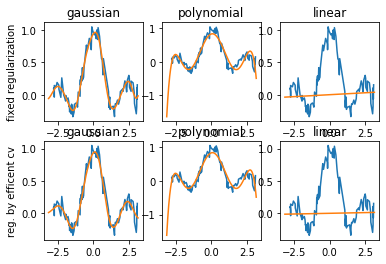

In [23]:
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
kernels = ['gaussian','polynomial','linear']
titles = ['gaussian','polynomial','linear']
params = [0.5,6,0]
regularizations = [ 0.01,0.01,0.01]
for i in range(3):
    for j in range(2):
        pl.subplot(2,3,1+i+3*j)
        if j==0:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=regularizations[i])
            model.fit(Xtr,Ytr)
        if j==1:
            model = krr(kernel=kernels[i],
                kernelparameter=params[i],
                regularization=0)
            model.fit(Xtr,Ytr)
        ypred = model.predict(Xte)
        pl.plot(Xtr,Ytr)
        pl.plot(Xte,ypred)
        if j==0 and i == 0:
            pl.ylabel('fixed regularization')
        if j==1 and i == 0:
            pl.ylabel('reg. by efficent cv')
        pl.title( titles[i] )
pl.show()


In [32]:
np.asarray(Ytr).shape

(100,)

In [29]:
as.aYtr.reshape(100,-1).shape

(100, 1)

Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)

pl.figure()
kernels = ['gaussian','polynomial','linear']
titles = ['gaussian','polynomial','linear']
params = [0.5,6,0]
regularizations = [ 0.01,0.01,0.01]

model = krr(kernel=kernels[0],
                kernelparameter=params[0],
                regularization=regularizations[0])

model.fit(Xtr,Ytr)

model.kernelmatrix

model.kernelmatrix

model.alpha.dot(model.kernelmatrix.reshape(len(Xtr), len(Xtr)))

Ytr

model.predict(Xte)

I_length = len(model.kernelmatrix)
#self.alpha = np.linalg.solve(self.kernelmatrix+self.regularization*np.identity(I_length), self.__ytrain).reshape(-1,len(self.__ytrain))
y_pred = (model.kernelmatrix+model.regularization*np.identity(I_length)).dot(model.alpha)

y_pred

float(y_pred[0])

float(Ytr[0])

 20%|██        | 2/10 [00:00<00:00, 18.57it/s]

Regularization range: 10**-4 .. 10**4
Gaussian kernel parameter:  0.615848211066026
Regularization paramter:  0.21544346900318834


100%|██████████| 10/10 [00:00<00:00, 24.09it/s]


Regularization via efficient leave on out
Kernel parameter:  1.6681005372000592
Regularization paramter:  5.179474679231214e-05


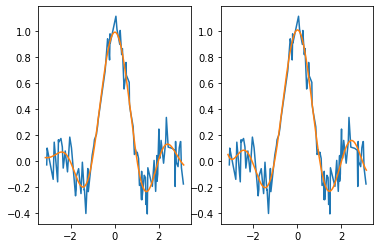

In [36]:
Xtr, Ytr = noisysincfunction(100, 0.1)
Xte = np.arange( -np.pi, np.pi, 0.01 ).reshape(-1, 1)
Ytr = Ytr.reshape(len(Ytr),-1)
pl.figure()
pl.subplot(1,2,1)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-4,4,20), 'regularization': np.logspace(-2,2,10) }
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization range: 10**-4 .. 10**4')
print('Gaussian kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)

pl.subplot(1,2,2)
params = { 'kernel': ['gaussian'], 'kernelparameter': np.logspace(-2,2,10), 'regularization': [0]}
cvkrr = cv(Xtr, Ytr, krr, params, loss_function=mean_absolute_error, nrepetitions=2)
ypred = cvkrr.predict(Xte)
print('Regularization via efficient leave on out')
print('Kernel parameter: ', cvkrr.kernelparameter)
print('Regularization paramter: ', cvkrr.regularization)

pl.plot(Xtr,Ytr)
pl.plot(Xte,ypred)
pl.show()

In [35]:
Ytr.shape

(100,)

In [30]:
class assignment3():
    """
    the object contains the tasks for assignment 3 of the ML Learning Course Excercise 3 
    """
    def __init__(self):
        """
        load data for assignment 3
        CAVEAT path to data might be different 
        """
        # load data 
        cwd = os.getcwd()
        file_name = 'qm7.mat'
        path_to_data = os.path.dirname(cwd ) + '/data/'+file_name
        assert os.path.exists(path_to_data), "The path does not excist."
        data = sio.loadmat(path_to_data)
        data_X = data['X'] # of shape 7165x23x23 
        self.y = data['T'].T
        # transform each msteolecule into a vector xi of R23 by eigenvalues of the M of R 23x23
        self.X, eigenvec = np.linalg.eigh(data_X)

        # Visualize data
        #plt.scatter(data['X'], data['R'])
    def distance_plot(self):
        """ 
        Excercise 3a
        calculate pairwise distance of the dataset
        """
        # calculate pairwise distance
        D = np.linalg.norm(self.X[None,:]-self.X[:,None], axis = 2)
        # calculate absolute energy difference
        y_abs_diff = abs(self.y[None,:,:] - self.y[:,:,None])
        # plot
        plt.figure(figsize=(8, 8))
        plt.plot(D,y_abs_diff.reshape(len(self.y),len(self.y)),'bo');
        plt.xlabel("||$x_{i}$ - $x_{j}$||")
        plt.ylabel("|$y_{i}$ - $y_{j}$|")
        
    def split_data(self):
        """
        # Excercise 3b
        Split data randomly into training set of 5000 and test of 2165 samples
        seed = 2
        """
        # split data
        # Random Partitioning
        X_pos = np.linspace(0,len(self.X)-1, len(self.X))
        random.Random(2).shuffle(X_pos)
        self.Xtr = self.X[X_pos[:5000].astype('int')]
        self.Xte = self.X[X_pos[5000:].astype('int')]
        self.Ytr = self.y[X_pos[:5000].astype('int')]
        self.Yte = self.y[X_pos[5000:].astype('int')]

    def fold_cross_validation(self):
        """
        # Excercise 3c
        Perform a cross validation on a training set of 2500
        Perform split_data before
        """
        # Fivefold Cross validation
        train_samples = random.sample(range(0, 5000), 2500)
        Xtr2500 = self.Xtr[train_samples]
        Ytr2500 = self.Ytr[train_samples]
        D2500= np.linalg.norm(Xtr2500[None,:]-Xtr2500[:,None], axis = 2)
        quantiles = np.quantile(D2500,[0.5])
        params = { 'kernel': ['gaussian'], 'kernelparameter': quantiles, 'regularization': np.logspace(-7,0, 2) }
        self.cvkrr = cv(Xtr2500, Ytr2500, krr, params, loss_function=mean_absolute_error, nfolds=5)
        y_pred2500 = self.cvkrr.predict(self.Xte)
        MAE = mean_absolute_error(self.Yte, y_pred2500)
        print("The mean absolute error is: {} ".format(round(MAE,2)))
        print("The best regularzation parameter C is: {}".format(self.cvkrr.regularization))
        print("The best kernelparameter sigma is: {}".format(self.cvkrr.kernelparameter))

    def plot_MAE_for_different_nsamples(self):
        """
        # Excercise 3d
        Plot MAE for different nsamples
        Perform fold_cross_validation before
        """
        MAE = []
        n_samples = [100,300,600,900,1200,1700,2000,2700,3000,3900,4200,4500,4700,4800,4900,4950,5000]
        for i in tqdm(n_samples):
            train_samples = random.sample(range(0, 5000), i)
            Xtr_nsample = self.Xtr[train_samples]
            Ytr_nsample = self.Ytr[train_samples]
            model = krr([self.cvkrr.kernel][0], [self.cvkrr.kernelparameter][0], [self.cvkrr.regularization])
            model.fit(Xtr_nsample, Ytr_nsample)
            y_pred = model.predict(self.Xte)
            MAE.append(mean_absolute_error(self.Yte,y_pred))
        plt.figure(figsize =(8,6))
        plt.plot(n_samples, MAE, 'bo')
        plt.xlabel("n training samples")
        plt.ylabel("Mean Absolute Error [kcal/mol]")
        
    def plot_energies_for_1000(self):
        """ 
        Excercise 3e, perform under-, well- and overfit for 1000 training samples
        """
        # split data
        # Random Partitioning
        X_pos = np.linspace(0,len(self.X)-1, len(self.X))
        random.Random(4).shuffle(X_pos)
        Xtr1000 = self.X[X_pos[:1000].astype('int')]
        Xte1000 = self.X[X_pos[1000:].astype('int')]
        Ytr1000 = self.y[X_pos[:1000].astype('int')]
        Yte1000 = self.y[X_pos[1000:].astype('int')]
        
        # get parameter for good fit
        # Fivefold Cross validation

        D1000= np.linalg.norm(Xtr1000[None,:]-Xtr1000[:,None], axis = 2)
        quantiles = np.quantile(D1000,[0.1,0.5, 0.9])
        params = { 'kernel': ['gaussian'], 'kernelparameter': quantiles, 'regularization': np.logspace(-7,0, 10) }
        cvkrr = cv(Xtr1000, Ytr1000, krr, params, loss_function=mean_absolute_error, nfolds=5)
        y_pred1000 = cvkrr.predict(Xte1000)
        MAE = mean_absolute_error(Yte1000, y_pred1000)
        
        # result of CV
        print("The mean absolute error is: {} ".format(round(MAE,2)))
        print("The best regularzation parameter C is: {}".format(cvkrr.regularization))
        print("The best kernelparameter sigma is: {}".format(cvkrr.kernelparameter))
        print("The cvloss: {}".format(cvkrr.cvloss))
        
        # define parameters for training
        params = { 'kernel': ['linear','gaussian', 'gaussian'], 'kernelparameter': [False, cvkrr.kernelparameter, 1], 'regularization': [cvkrr.regularization, cvkrr.regularization, 0] }
        
        # plot
        plt.figure(figsize =(10,6))
        for i in [0,1,2]:
            model = krr(params['kernel'][i], params['kernelparameter'][i], params['regularization'][i])
            model.fit(Xtr1000,Ytr1000)
            y_pred_train = model.predict(Xtr1000)
            y_pred = model.predict(self.Xte)
            plt.subplot(1,3,i+1)
            plt.plot(self.Yte,y_pred,'bo')
            plt.plot(Ytr1000,y_pred_train,'ro')
            plt.xlabel("y_true")
            plt.ylabel("y_pred")
            plt.legend(labels = ['test', 'train'])
        plt.tight_layout(pad=3.0)




 12%|█▏        | 2/17 [00:00<00:00, 18.16it/s]

The mean absolute error is: 90.77 
The best regularzation parameter C is: 1.0
The best kernelparameter sigma is: 22.0502872467041


100%|██████████| 30/30 [00:24<00:00,  1.23it/s]


The mean absolute error is: 16.19 
The best regularzation parameter C is: 2.1544346900318867e-05
The best kernelparameter sigma is: 50.44218254089354
The cvloss: 19.663841365319016


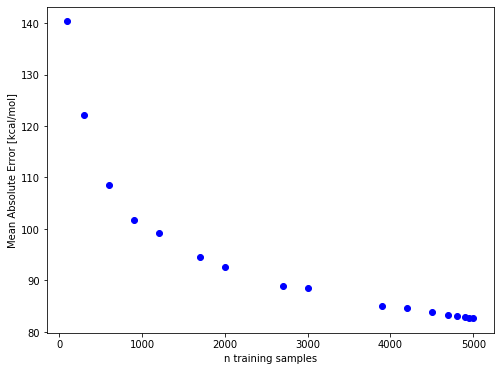

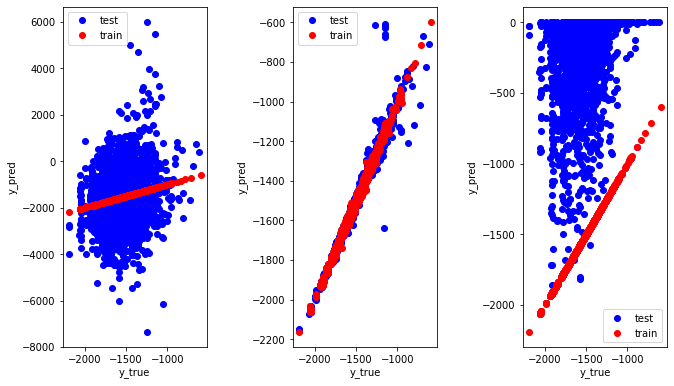

In [31]:

assign = assignment3()
# Excecise 3a - takes long
#assign.distance_plot()
# Excecise 3b
assign.split_data()
# Excecise 3c
assign.fold_cross_validation()
# Excecise 3d
assign.plot_MAE_for_different_nsamples()
# Excecise 3e
assign.plot_energies_for_1000()